# Diagnostic Functions

## Introduction
Here we are laying the groundwork for a revision of Cambio in which diagnostic variables are calculated by means of Python functions, with unit testing. Here's what you need to know for now:

- *Parametric variables are collected in a dictionary*. A dictionary has been defined to contain parameters associated with a given climate system, such as a climate sensitivity parameter, and flux constants. These values wouldn't change over the course of a climate simulation.
- *Diagnostic functions are implemented as Python functions*. Much of the work of translating those parameters into diagnostic variables (and, ultimately, prognostic ones) has been relegated to Python functions. This includes straightforward conversions, like the temperature converted to Fahrenheit, but also more complex dependencies. (*Diagnose_albedo*, for example, infers a planetary albedo from the current temperature anomaly.) These diagnostic functions are accompanied by tests to help verify they're working correctly. 

Some diagnostic functions lay the groundwork for feedbacks that will eventually convert the diagnostic variable into a prognostic one. But we'll worry about that later. 

We're also introducing a new sigmoid function here, called $\sigma_{floor}$. This function is a lot like our old $\sigma_{down}$ function, but instead of going to zero, it bottoms out at a value that's smaller than 1, but bigger than zero (the "floor"), that you get to specify. This will be useful, for example, when specifying the atmosphere-to-land flux in a new climate regime, in which,we expect photosynthesis to be reduced, but not entirely eliminated, by higher temperatures.

## Computing skills

1. I can translate mathematical formulas into algorithmic form.
1. I can create and use Python dictionaries.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Conn350Lib as CL

In [17]:
%matplotlib notebook

## Describing climate parameters as a dictionary
Executing the cell below creates a dictionary of climate parameters.

In [18]:
# Start with an empty dictionary
ClimateParams = {}

# Preindustrial climate values
ClimateParams['preindust_C_atm'] = 615
ClimateParams['preindust_C_ocean'] = 350
ClimateParams['preindust_albedo'] = 0.3
ClimateParams['preindust_pH'] = 8.2

# Parameter for the basic sensitivity of the climate to increasing CO2
ClimateParams['climate_sensitivity'] = 3/ClimateParams['preindust_C_atm'] # IPCC: 3 degrees for doubled CO2

# Carbon flux constants
ClimateParams['k_la'] = 120
ClimateParams['k_al0'] = 113
ClimateParams['k_al1'] = 0.0114
ClimateParams['k_oa'] = 0.2
ClimateParams['k_ao'] = 0.114

# Parameter for the ocean degassing flux feedback
ClimateParams['DC'] = 0.034 # Pretty well known from physical chemistry

# Parameters for albedo feedback
ClimateParams['albedo_sensitivity'] = -100 # Based on our radiative balance sensitivity analysis
ClimateParams['albedo_transition_temperature'] = 3 # A guess at the T at which significant albedo reduction kicks in
ClimateParams['albedo_transition_interval'] = 1 # Also a guess: Over what temperature range will albedo reduction kick in?
ClimateParams['max_albedo_change_rate'] = 0.0005 # Also a guess, this controls how fast albedo can change in a year
ClimateParams['fractional_albedo_floor'] = 0.9 # Also a guess: .9 would be a 10% maximum reduction in albedo

# Parameters for the atmosphere->land flux feedback
ClimateParams['F_al_transitionT'] = 2 # Pretty much a guess: at what T will photosynthesis be impaired?
ClimateParams['F_al_transitionTinterval'] = 1 # Also a guess
ClimateParams['fractional_F_al_floor'] = 0.9 # Also a guess: .9 would be a 10% maximum reduction in F_al

# Parameter for stochastic processes
ClimateParams['Stochastic_C_atm_std_dev'] = 3

# This displays the dictionary contents
display(ClimateParams)

{'preindust_C_atm': 615,
 'preindust_C_ocean': 350,
 'preindust_albedo': 0.3,
 'preindust_pH': 8.2,
 'climate_sensitivity': 0.004878048780487805,
 'k_la': 120,
 'k_al0': 113,
 'k_al1': 0.0114,
 'k_oa': 0.2,
 'k_ao': 0.114,
 'DC': 0.034,
 'albedo_sensitivity': -100,
 'albedo_transition_temperature': 3,
 'albedo_transition_interval': 1,
 'max_albedo_change_rate': 0.0005,
 'fractional_albedo_floor': 0.9,
 'F_al_transitionT': 2,
 'F_al_transitionTinterval': 1,
 'fractional_F_al_floor': 0.9,
 'Stochastic_C_atm_std_dev': 3}

### Your turn
In the cell below, add a new climate parameter called 'ScheduledFlowsFile'. You can give this parameter any string value you like; the idea, however, is that it will be the name of the file that contains your Scheduled Flows (i.e., your $\epsilon(t)$ file).

After adding this parameter, use "display(ClimateParams)" to verify that it was added properly.

In [19]:
# Add the of your scheduled anthropogenic emissions file to the dictionary
### BEGIN SOLUTION
ClimateParams['ScheduledFlowsFile'] = 'Peaks_in_2030.hdf5'
### END SOLUTION

# Display your updated dictionary
### BEGIN SOLUTION
display(ClimateParams)
### END SOLUTION

{'preindust_C_atm': 615,
 'preindust_C_ocean': 350,
 'preindust_albedo': 0.3,
 'preindust_pH': 8.2,
 'climate_sensitivity': 0.004878048780487805,
 'k_la': 120,
 'k_al0': 113,
 'k_al1': 0.0114,
 'k_oa': 0.2,
 'k_ao': 0.114,
 'DC': 0.034,
 'albedo_sensitivity': -100,
 'albedo_transition_temperature': 3,
 'albedo_transition_interval': 1,
 'max_albedo_change_rate': 0.0005,
 'fractional_albedo_floor': 0.9,
 'F_al_transitionT': 2,
 'F_al_transitionTinterval': 1,
 'fractional_F_al_floor': 0.9,
 'Stochastic_C_atm_std_dev': 3,
 'ScheduledFlowsFile': 'Peaks_in_2030.hdf5'}

## Diagnostic algorithms in functional form
In this part, you'll be developing code that allow you to calculate diagnostic variables. For each algorithm,

1. We describe the algorithm in mathematical terms (you don't have to change this).
2. In a code cell, you should
- implement the algorithm as a Python *function*
- run the function through some benchmark tests 

### Diagnose_F_la
Recommended algorithm: $F_{al} = k_{la}$, where  Here, $k_{la}$ is specified in ClimateParameters.

Benchmark value:
- $F_{la} = 120 \ GtC/yr $ regardless of the state of the climate

This is all done for you in the cell below! You just need to execute it.

In [20]:
def Diagnose_F_la(ClimateParams):
    """Computes the terrestrial carbon sink"""
    
    k_la = ClimateParams['k_la']
    F_la = k_la
    return F_la

# Testing the algorithm
print(Diagnose_F_la(ClimateParams))

120


### Diagnose_OceanSurfacepH
Recommended algorithm: $pH = -log_{10}(\frac {C_{atm}}{C_{atm,pre-industrial}})+pH_{pre-industrial}$

Benchmark values:
- $pH = 8.2$ if C_atm is the preindustrial value (615 GtC)
- $pH \approx 7.9$ if C_atm is double the preindustrial value (1230 GtC)

Don't forget that numpy's log-base-ten function is np.log10.

In [21]:
# Implementing the algorithm
def Diagnose_OceanSurfacepH(C_atm,ClimateParams):
    """Computes ocean pH as a function of atmospheric CO2"""

    # Extract needed climate parameters
    preindust_pH = ClimateParams['preindust_pH']
    preindust_C_atm = ClimateParams['preindust_C_atm']
    
    # Calculate the new pH according to our algorithm
    ### BEGIN SOLUTION
    pH = -np.log10(C_atm/preindust_C_atm)+preindust_pH
    ### END SOLUTION

    # Return our diagnosed pH value
    return(pH)

# Testing the algorithm for the pre-industrial atmospheric carbon amount (615 GtC)
print(Diagnose_OceanSurfacepH(615,ClimateParams))

# Testing the algorithm for 2x pre-industrial atmospheric carbon amount
### BEGIN SOLUTION
print(Diagnose_OceanSurfacepH(1230,ClimateParams))
### END SOLUTION

8.2
7.898970004336018


### Diagnose_T_anomaly
Recommended algorithm: $T_{anomaly} = CS\times(C_{atm}-C_{atm,pre-industrial})$, where $CS$ is the climate sensitivity (degrees warming per GtC increase in atmospheric $CO_2$).

Benchmark values:
- $T_{anomaly}=0$ when $C_{atm}=C_{atm,pre-industrial}$
- $T_{anomaly} \approx +1.3 $ when $C_{atm}=890 \ GtC$ (the current atmospheric carbon amount!)

In [22]:
# Implementing the algorithm
def Diagnose_T_anomaly(C_atm, ClimateParams):
    """Computes a temperature anomaly from the atmospheric carbon amount"""

    # Extract the climate sensitivity and the preindustrial C_atm
    ### BEGIN SOLUTION
    CS = ClimateParams['climate_sensitivity']
    preindust_C_atm = ClimateParams['preindust_C_atm']
    ### END SOLUTION
    
    # Calculate the temperature anomaly according to our algorithm
    ### BEGIN SOLUTION
    T_anomaly = CS*(C_atm-preindust_C_atm)
    ### END SOLUTION

    # Return our diagnosed pH value
    return(T_anomaly)

# Testing the algorithm for the pre-industrial atmospheric carbon amount (615 GtC)
print(Diagnose_T_anomaly(615,ClimateParams))

# Testing the algorithm for 890 GtC)
### BEGIN SOLUTION
print(Diagnose_T_anomaly(890,ClimateParams))
### END SOLUTION

0.0
1.3414634146341464


### Diagnose_actual_temperature
Recommended algorithm: $T(actual,C) = (T_{anomaly}+14) $.

Benchmark values:
- a temperature of 14 degrees C if the temperature anomaly is zero
- a temperature of 15 degrees C if the temperature anomaly is +1

In [23]:
# Implementing the algorithm
def Diagnose_actual_temperature(T_anomaly):
    """Computes degrees C from a temperature anomaly"""

    ### BEGIN SOLUTION
    T_C = T_anomaly+14
    ### END SOLUTION

    # Return our diagnosed temperature in degrees C
    return(T_C)

# Testing the algorithm for a temperature anomaly of zero
### BEGIN SOLUTION
print(Diagnose_actual_temperature(0))
### END SOLUTION

# Testing the algorithm for a temperature anomaly of +1 degrees
### BEGIN SOLUTION
print(Diagnose_actual_temperature(1))
### END SOLUTION

14
15


### Diagnose_degreesF
Recommended algorithm: $T(actual,F) = T(actual,C) \times 9 /5 + 32$, where $T(actual,C)$ is in degrees Celsius.

Benchmark values:
- a temperature of $32 \ F$ if $T(C,actual)=0 \ C$ (freezing temperature of water)
- a temperature of $212 \ F$ if $T(C,actual)=100 \ C$ (boiling temperature of water)

In [24]:
def Diagnose_degreesF(T_C):
    """Converts temperature from C to F"""

    # Do the conversion to F
    ### BEGIN SOLUTION
    T_F = T_C*9/5+32
    ### END SOLUTION

    # Return the diagnosed temperature in F
    return(T_F)

# Testing the algorithm for freezing water (T = 0 degrees C)
### BEGIN SOLUTION
print(Diagnose_degreesF(0))
### END SOLUTION

# Testing the algorithm for boiling water (T = 100 degrees C)
### BEGIN SOLUTION
print(Diagnose_degreesF(100))
### END SOLUTION

32.0
212.0


### Diagnose_F_ao
Recommended algorithm: $F_{ao} = k_{ao} \times C_{atm}$.

Benchmark values:
- $F_{ao} \approx 70$ if the atmosphere contains 615 GtC 
- $F_{ao} \approx 101$ if the atmosphere contains 890 GtC 

In [25]:
def Diagnose_F_ao(C_atm, ClimateParams):
    """Computes flux of carbon from atm to ocean"""

    # Calculate the F_ao based on k_ao and the amount of carbon in the atmosphere
    ### BEGIN SOLUTION
    k_ao = ClimateParams['k_ao']
    F_ao = k_ao*C_atm
    ### END SOLUTION
    
    # Return the diagnosed flux
    return F_ao

# Testing the algorithm for 615 GtC
### BEGIN SOLUTION
print(Diagnose_F_ao(615, ClimateParams))
### END SOLUTION

# Testing the algorithm for 890 GtC
### BEGIN SOLUTION
print(Diagnose_F_ao(890, ClimateParams))
### END SOLUTION

70.11
101.46000000000001


### Diagnose_F_oa
Recommended algorithm: $F_{oa} = k_{oa} (1+T_{anomaly} \times DC) \times C_{ocean}$ where $DC$ is the degassing coefficient for $CO_2$ in water.

Benchmark values:
- $F_{oa} = 70 \ GtC/yr$ if the temperature anomaly is zero and the ocean carbon amount is 350 GtC
- $F_{oa} \approx 93 \ GtC/yr$ if the temperature anomaly is 1 degree and the ocean carbon amount is 450 GtC

In [26]:
def Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams):
    """Computes a temperature-dependent degassing flux of carbon from the ocean"""

    ### BEGIN SOLUTION
    DC = ClimateParams['DC']
    k_oa = ClimateParams['k_oa']
    F_oa = k_oa*(1+DC*T_anomaly)*C_ocean
    ### END SOLUTION
    
    # Return the diagnosed flux
    return F_oa

# When the temperature anomaly is zero and the ocean carbon amount is 350 GtC ...
print(Diagnose_F_oa(350, 0, ClimateParams))

# When the temperature anomaly is 1 degree and the ocean carbon amount is 450 GtC ...
### BEGIN SOLUTION
print(Diagnose_F_oa(450, 1, ClimateParams))
### END SOLUTION

70.0
93.06


### Diagnose_F_al
Recommended algorithm: $F_{al} = k_{al0} + k_{al1} \times \sigma_{floor} \times C_{atm}$. Here, $\sigma_{floor}$ is a function that goes from 1 to a smaller value (not zero), so it controls how low the atmosphere-to-land flux can become. You invoke it using syntax like

    CL.sigmafloor(T_anomaly, F_al_transitionT, F_al_transitionTinterval, floor)

Benchmark values:
- $F_{al} \approx 120 \ GtC/yr $ if the concentration of carbon in the atmosphere is 615, and the temperature anomaly is zero.
- $F_{al} \approx 123 \ GtC/yr $ if the concentration of carbon in the atmosphere is 890 GtC, and the temperature anomaly is +1 degrees.

120.00926644390488
123.09788170907404


<IPython.core.display.Javascript object>


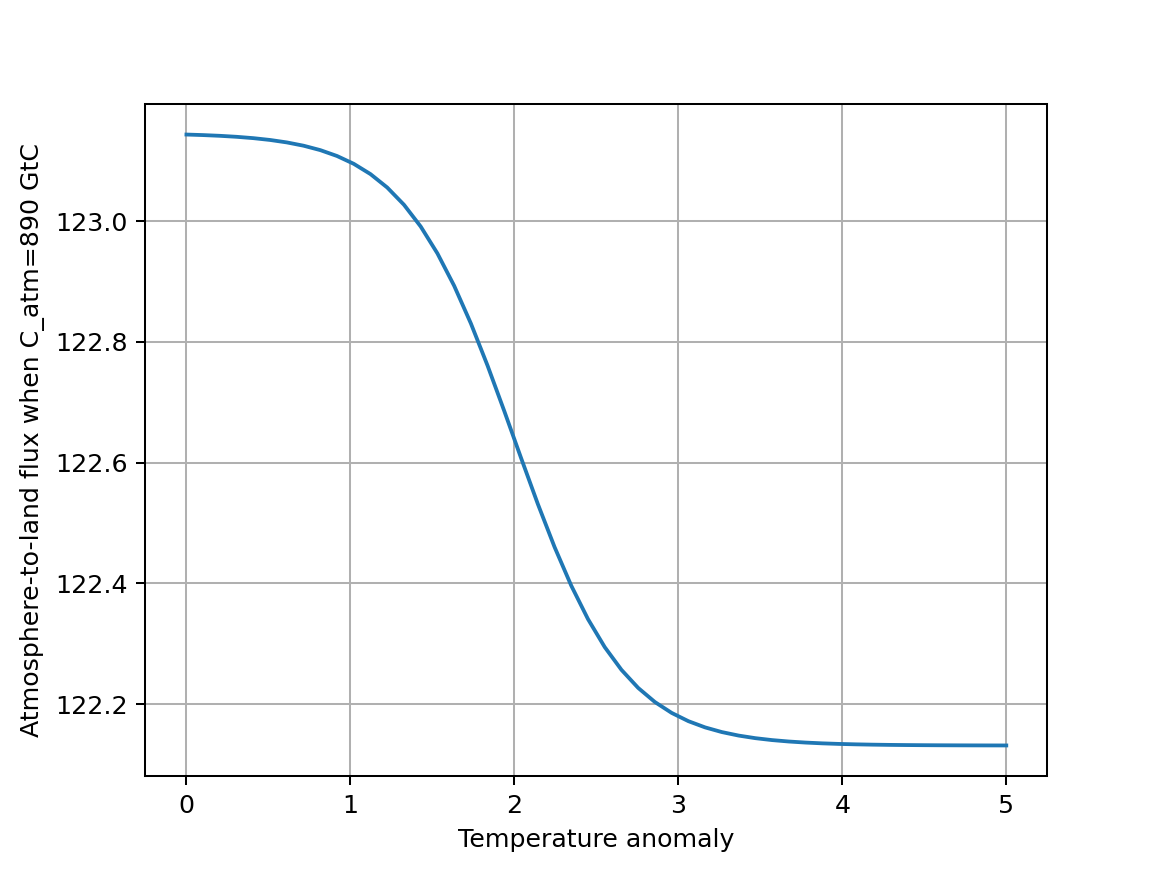

Text(0, 0.5, 'Atmosphere-to-land flux when C_atm=890 GtC')

In [31]:
def Diagnose_F_al(T_anomaly, C_atm, ClimateParams):
    """Computes the terrestrial carbon sink"""
    
    # Extract parameters we need from ClimateParameters, and calculate a new flux
    ### BEGIN SOLUTION
    k_al0 = ClimateParams['k_al0']
    k_al1 = ClimateParams['k_al1']
    F_al_transitionT = ClimateParams['F_al_transitionT']
    F_al_transitionTinterval = ClimateParams['F_al_transitionTinterval']
    floor = ClimateParams['fractional_F_al_floor'] 
    F_al = k_al0 + k_al1*CL.sigmafloor(T_anomaly,F_al_transitionT,F_al_transitionTinterval,floor)*C_atm
    ### END SOLUTION
    
    # Return the diagnosed flux
    return F_al

# Testing the algorithm at 615 and 890 GtC
### BEGIN SOLUTION
print(Diagnose_F_al(0, 615, ClimateParams))
print(Diagnose_F_al(1, 890, ClimateParams))


# Not part of the solution, but interesting to look at:
T_anomaly = np.linspace(0,5)
F_al = Diagnose_F_al(T_anomaly, 890, ClimateParams)
plt.figure()
plt.plot(T_anomaly,F_al)
plt.grid(True)
plt.xlabel('Temperature anomaly')
plt.ylabel('Atmosphere-to-land flux when C_atm=890 GtC')
### END SOLUTION

### Diagnose_albedo
Recommended algorithm: $\alpha = \alpha_{pre-industrial} \times \sigma_{floor}$. Here, $\sigma_{floor}$ is the same function used by Diagnose_F_al; in this context, it controls how low the albedo can get. The floor, transition year and the transition time interval are specified in ClimateParameters.

Benchmark values:
- $\alpha = 0.30 $ if the temperature anomaly is zero
- $\alpha \approx 0.27 $ if the temperature anomaly is +4 degrees and the parameters are the default ones (transition temperature of 2 degrees, transition temperature interval of 1 degree, and a fractional albedo floor of 0.9).

In [28]:
def Diagnose_albedo(T_anomaly, ClimateParams):
    """Returns the albedo as a function of temperature"""
        
    # Extract parameters we need from ClimateParameters, and calculate a new albedo
    ### BEGIN SOLUTION
    transitionT = ClimateParams['albedo_transition_temperature'] 
    transitionTinterval = ClimateParams['albedo_transition_interval'] 
    preindust_albedo = ClimateParams['preindust_albedo']
    floor = ClimateParams['fractional_albedo_floor']
    albedo = CL.sigmafloor(T_anomaly,transitionT,transitionTinterval,floor)*preindust_albedo
    ### END SOLUTION
    
    # Return the diagnosed flux
    return albedo

# Testing the algorithm for temperature anomaly of zero
print(Diagnose_albedo(0, ClimateParams))

# Testing the algorithm for a temperature anomaly of +4 degrees
### BEGIN SOLUTION
print(Diagnose_albedo(4, ClimateParams))
print(Diagnose_albedo(2, ClimateParams))
### END SOLUTION

0.2999962981627204
0.271422776195327
0.298577223804673


### Diagnose_Delta_T_from_albedo
Recommended algorithm: $ \Delta T_{from \ albedo} = AS \times (\alpha - \alpha_{preindust})$ where $AS$ is the albedo sensitivity parameter.

Benchmark values:
- $\Delta T_{from \ albedo} = 0$ if the albedo is the pre-industrial value (0.3).
- $\Delta T_{from \ albedo} = +1 \ C $ if the albedo is 0.29.

In [29]:
def Diagnose_Delta_T_from_albedo(albedo,ClimateParams):
    """Computes additional planetary temperature increase resulting from a lower albedo"""
    """Based on the idea of radiative balance, ASR = OLR"""
    
    # Extract parameters we need and make the diagnosis
    ### BEGIN SOLUTION
    AS = ClimateParams['albedo_sensitivity']    
    preindust_albedo = ClimateParams['preindust_albedo']
    Delta_T_from_albedo = (albedo-preindust_albedo)*AS
    ### END SOLUTION
    
    return Delta_T_from_albedo

# Testing the algorithm when the albedo = 0.3
print(Diagnose_Delta_T_from_albedo(.3,ClimateParams))

# Testing the algorithm when the albedo = 0.29
### BEGIN SOLUTION
print(Diagnose_Delta_T_from_albedo(.29,ClimateParams))
### END SOLUTION

-0.0
1.0000000000000009


### Diagnose_Stochastic_C_atm
Recommended algorithm: $C_{atm}$ = is displaced by a random number, up or down. The test consists of handing the algorithm a value for $C_{atm}$, and checking that the value handed back is close to that value (but not exactly equal, 'cuz it's been randomized).

Numpy has a nice function for this, called np.random.normal. If you give it a value to work from, it'll hand back a value up or down from that, assuming a given standard deviation. The call looks like this: 

    np.random.normal(C_atm, Stochastic_C_atm_std_dev)
    

In [30]:
def Diagnose_Stochastic_C_atm(C_atm,ClimateParams):
    """Returns a noisy version of T"""
    
    # Extract parameters we need and make the diagnosis
    ### BEGIN SOLUTION
    Stochastic_C_atm_std_dev = ClimateParams['Stochastic_C_atm_std_dev']
    C_atm_new = np.random.normal(C_atm, Stochastic_C_atm_std_dev)
    ### END SOLUTION
    return C_atm_new 

# Testing the algorithm at 616 GtC
print(Diagnose_Stochastic_C_atm(615,ClimateParams))

# Testing the algorithm agin at 616 GtC (you should get a different number!)
### BEGIN SOLUTION
print(Diagnose_Stochastic_C_atm(615,ClimateParams))
### END SOLUTION

615.6582742687872
615.9825828237781


### Refresh/save/validate
Double-check everything is OK, and press the "Validate" button (as usual).

### Close/submit/logout
Close, submit, and log out.